In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm,invgamma
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
from statsmodels.tsa.arima_process import ArmaProcess
path_to_directory = '/home/michele/Scrivania/plots/back_up_start/PhD/market/notes/econophysix/'

In [142]:
#######################################################

            # HERE WE SIMULATE THE RELAXATIONAL DYNAMICS

#######################################################
def correlation(x, y, taus):
    """Inputs :
    x: pd.Series
    y: pd.Series
    taus: array of integers
    Returns:
    A numpy array containing the correlation function as the average x(t)*y(t+tau)
    for each value of tau in taus"""
    def c_group(T):
        return (x*y.shift(-T)).mean()
    c_g = np.vectorize(c_group)
    return c_g(taus)
def Compute_corr(df,T_corr,n):
    Corr = np.zeros(T_corr)
    for i in range(0,n):
        Corr+= correlation(df[i],df[i],np.arange(0,T_corr))/n
    return Corr

def simulate(l0,hat_v_F,hat_eps,sigma,tau,alpha,S,deltaeps):
    #return b_I,b_N,L,v_p
    
    v_tgt = 1
    v_F = 1
    
    L = np.zeros(tau)
    b_I = np.zeros(tau)
    b_N = np.zeros(tau)
    hat_b_N = np.zeros(tau)
    v_p = np.zeros(tau)
    eps = np.zeros(tau)
    
    eps = hat_eps+deltaeps

    r = 2*(1-hat_eps)*eps/(1-eps**2)*(np.sqrt(1+2*S*(S+np.sqrt(1+S**2)))+(S+np.sqrt(1+S**2))*eps)/(1+2*S*(S+np.sqrt(1+S**2)))

   
    for i in range(0,tau):
        if i ==0:
    
            b_I[i] = 1/(2*l0)
    
            hat_b_N[i] = 1/(1+2*hat_eps*(np.sqrt(1+S**2)-S)*l0)
    
            L[i] = (b_I[i]*hat_v_F+S*hat_b_N[i]*np.sqrt(hat_v_F*v_tgt))/(b_I[i]**2*hat_v_F+hat_b_N[i]**2*hat_v_tgt)
    
        else:
            b_I[i] = 1/(2*L[i-1])
        
            hat_b_N[i] = 1/(1+2*hat_eps*(np.sqrt(1+S**2)-S)*L[i-1])
            
            L[i] = (b_I[i]*hat_v_F+S*hat_b_N[i]*np.sqrt(hat_v_F*v_tgt))/(b_I[i]**2*hat_v_F+hat_b_N[i]**2*hat_v_tgt)
            
            
    b_N = 1/(1+r*L)
            
    v_p = L**2*(b_I**2*v_F+b_N**2*v_tgt)
    
    return b_I,b_N,L#,v_p


def calculate_var_p(b_I,b_N,L,S,p_F,q_tgt):

    q = b_I*p_F+b_N*q_tgt
    p = L*q

    var_p = np.var(p)
    
    return 2*var_p/(1+S*(S+np.sqrt(1+S**2))),p,q

########### HERE I CONCATENATE THE TWO PROCESSES

def Simulate(T,n,hat_eps,sigma,l0,hat_v_F,alpha,S):
    BIT = []
    BNT = []
    Lambda = [l0]
    V_P_th = []
    V_F_exp = [hat_v_F]
    P = []
    PF = []
    
    ar1 = np.array([1, -alpha])
    ma1 = np.array([1])
    AR_object1 = ArmaProcess(ar1, ma1)
    deltaeps = AR_object1.generate_sample(nsample=n*T)*np.sqrt(1-alpha**2)*sigma
    v_tgt = 1
    v_F = 1
    
    p_F = np.random.normal(0,np.sqrt(v_F),T*n)
    q_tgt = np.random.normal(0,np.sqrt(v_tgt),T*n)
    
    for i in range(0,n):
    
        if i ==0:
            
            b_IT,b_NT,L,= simulate(l0,hat_v_F,hat_eps,sigma,T,alpha,S,deltaeps[:T])
            hat_v_F_new,p,q = calculate_var_p(b_IT,b_NT,L,S,p_F[:T],q_tgt[:T])
        
            V_F_exp = np.append(V_F_exp,hat_v_F_new)
            Q = q
            P = p
            
        else:
            b_IT,b_NT,L = simulate(L[T-1],hat_v_F_new,hat_eps,sigma,T,alpha,S,deltaeps[i*T:(i+1)*T])
            hat_v_F_new,p,q = calculate_var_p(b_IT,b_NT,L,S,p_F[(i)*T:(i+1)*T],q_tgt[(i)*T:(i+1)*T])
        
            V_F_exp = np.append(V_F_exp,hat_v_F_new)
            Q = np.append(Q,q)
            P = np.append(P,p)
            
    return V_F_exp,P,Q

def Sim(params):
    m = params[1]
    for i in range(0,m):
        print(i)
        T,n,hat_eps,sigma,l0,hat_v_F,alpha,S = params[0][:,i]
        T = int(T)
        n = int(n)
        if i==0:
            vf,p,q = Simulate(T,n,hat_eps,sigma,l0,hat_v_F,alpha,S)
            Vf = np.asarray([vf])
            P  = np.asarray([p])
            Q  = np.asarray([q])
    
        else:
            vf,p,q = Simulate(T,n,hat_eps,sigma,l0,hat_v_F,alpha,S)
            Vf = np.concatenate((Vf,np.asarray([vf])),axis = 0)
            P = np.concatenate((P,np.asarray([p])),axis = 0)
            Q = np.concatenate((Q,np.asarray([q])),axis = 0)
    return Vf,P,Q

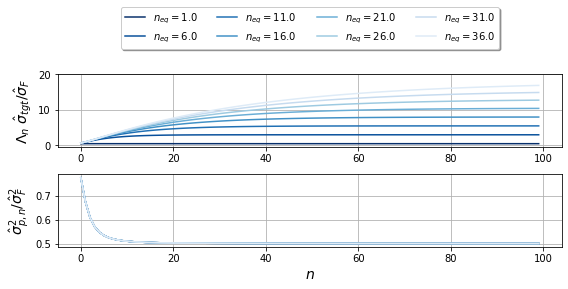

In [230]:
plt.rcParams["figure.figsize"] = (8,4)

l0= 0.4
hat_v_F= 1
hat_v_tgt = 1
sigma = 0
tau= 100
alpha = 0
fig, axs = plt.subplots( 2)
m = 8
norm = mpl.colors.Normalize(vmin=0, vmax=m)

cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
for i in range(0,m):
    
    hat_eps = 1-1/(1+5*i)
    S = 0
    b_I,b_N,L = simulate(l0,hat_v_F,hat_eps,sigma,tau,alpha,S, np.arange(0,tau))
    axs[0].plot(L,color = cmap.to_rgba(m-i), label = r'$n_{eq}=$'+str(round(1/(1-hat_eps),1)))
    axs[1].plot(v_p,color = cmap.to_rgba(m-i))
axs[0].legend(fontsize = 10)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 2),
          ncol=4, fancybox=True, shadow=True)
plt.tight_layout()
axs[0].set_ylabel(r'$\Lambda_n \  \hat\sigma_{tgt}/\hat\sigma_F $', size = 14)
axs[0].set_yticks([0,10,20])
axs[0].grid()
axs[1].set_ylabel(r'$\hat\sigma^2_{p,n}/\hat\sigma^2_F$', size = 14)
axs[1].grid()
axs[1].set_xlabel(r'$n$', size = 14)
plt.tight_layout()
plt.savefig(path_to_directory+'relax.pdf')
plt.show()

In [284]:
%%time

n = 300
tau = 1
hat_eps = np.exp(-1/tau)
hat_eps = 0
l0 = 0.5
hat_v_F = 1
m=4
sigma =0
alpha = 0
Vf = np.asarray([[]])

for i in range(0,4):
    print(i)
    if i==0:
        T = 10**(i+1)
        vf = Simulate(T,n,hat_eps,sigma,l0,hat_v_F,alpha,S)
        Vf = np.asarray([vf])
    
    else:
        T = 10**(i+1)
        vf = Simulate(T,n,hat_eps,sigma,l0,hat_v_F,alpha,S)
        Vf = np.concatenate((Vf,np.asarray([vf])),axis = 0)

0
1
2
3
CPU times: user 18.6 s, sys: 7.88 ms, total: 18.6 s
Wall time: 18.6 s


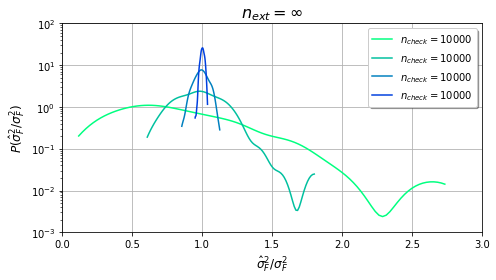

CPU times: user 1.49 s, sys: 16 ms, total: 1.5 s
Wall time: 1.5 s


In [285]:
%%time
plt.rcParams["figure.figsize"] = (7,4)
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.winter)

plt.title(r'$n_{ext} = \infty$', size = 16)
plt.ylabel('$P(\hat\sigma^2_F/\sigma^2_F) $', size = 12)
plt.xlabel('$\hat\sigma^2_F/\sigma^2_F $', size = 12)

for i in range(0,len(Vf)):
    
    density = stats.gaussian_kde(Vf[i])
    a, x, _ = plt.hist(Vf[i], bins=100, density=True, color = 'white') 
    plt.plot(x, density(x),label = r'$n_{check}=$'+str(T),color = cmap1.to_rgba(m-i))
    
#plt.legend(fontsize = 10)
plt.legend(loc=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.ylim(0.001,100)
plt.xlim(0,3)
plt.grid(True)
plt.tight_layout()
plt.savefig(path_to_directory+'fixed_world.pdf')
plt.show()

In [388]:
#%%prun -s cumulative

m=7


T = 10**3*np.ones(m)
n = 1000*np.ones(m)
hat_eps = 0*np.ones(m)
sigma = 0.08*np.ones(m)
l0 = 0.4*np.ones(m)
hat_v_F = 1*np.ones(m)
S = 0*np.ones(m)

alpha = np.ones(m)
for i in range(0,m):
    tau = 10**i
    alpha[i] = np.exp(-1/tau)
    

params = [np.asarray([T,n,hat_eps,sigma,l0,hat_v_F,alpha,S]),m]



Vf = Sim(params)


0
1
2
3
4
5
6


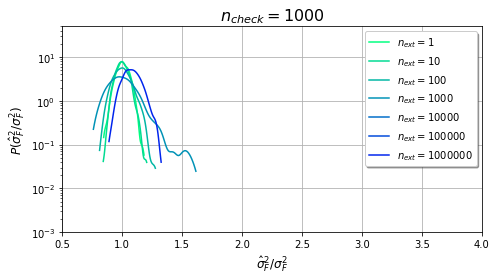

In [389]:
plt.rcParams["figure.figsize"] = (7,4)
norm = mpl.colors.Normalize(vmin=0, vmax=m)
cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.winter)
    
plt.title(r'$n_{check} = 1000$', size = 16)
plt.ylabel('$P(\hat\sigma^2_F/\sigma^2_F) $', size = 12)
plt.xlabel('$\hat\sigma^2_F/\sigma^2_F $', size = 12)
for i in range(0,len(Vf)):
    density = stats.gaussian_kde(Vf[i])
    a, x, _ = plt.hist(Vf[i], bins=100, density=True, color = 'white') 
    plt.plot(x, density(x),label = r'$n_{ext}=$'+str(10**i),color = cmap1.to_rgba(m-i))
    
plt.legend(loc=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.ylim(0.001,50)
plt.xlim(0.5,4.0)
plt.grid(True)
plt.tight_layout()
plt.savefig(path_to_directory+'changing_world.pdf')
plt.show()

In [222]:
%%time
n = 2000
T = 250
hat_eps = 0
l0 = 0.5
hat_v_F = 1
hat_v_tgt = 1
m=100
sigma = 0.05
tau = 10
alpha = np.exp(-1/tau)

Vf = np.zeros((m,n+1))
Q = np.zeros((m,n*T))
P = np.zeros((m,n*T))

S = 2.4


for j in range(0,m):
    print(j)
    vf,p,q = Simulate(T,n,hat_eps,sigma,l0,hat_v_F,alpha,S)
    Vf[j] = vf
    Q[j] = q
    P[j] = p

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 6min 4s, sys: 518 ms, total: 6min 4s
Wall time: 6min 4s


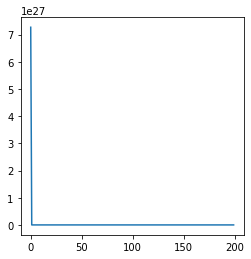

In [200]:
df = pd.DataFrame(Vf.transpose())
df_Q = pd.DataFrame(Q.transpose())
df_P = pd.DataFrame(P.transpose())

plt.plot(Compute_corr(df,200,m))
plt.show()

<AxesSubplot:>

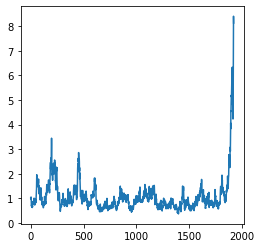

In [221]:
df[5][:1920].plot()

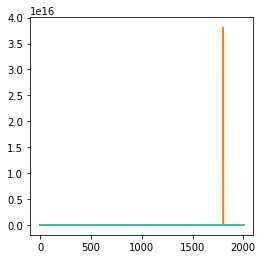

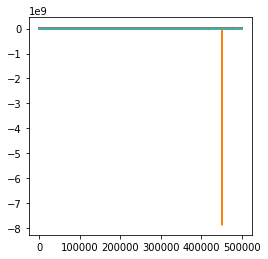

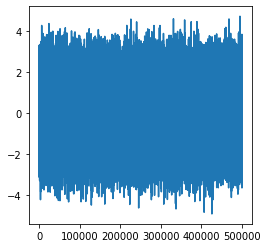

In [201]:
plt.plot(Vf.transpose())
plt.show()
plt.plot(P.transpose())
plt.show()
plt.plot(q.transpose())
plt.show()

0.5886716164237766 0.27242219961785796 0.6616828466125214


/home/michele/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


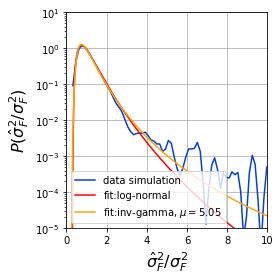

In [198]:
plt.rcParams["figure.figsize"] = (7,4)
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.winter)
plt.rcParams["figure.figsize"] = (4,4)
density = stats.gaussian_kde(Vf.flatten())
a, x, _ = plt.hist(Vf.flatten(), bins=100, density=True, color = 'white') 
plt.plot(x, density(x),label = 'data simulation',color = cmap1.to_rgba(m-j))
shape,loc,scale = lognorm.fit(Vf.flatten())

x = np.arange(0, 2000)/100
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r', label = 'fit:log-normal')


print(shape,loc,scale)
shape,loc,scale = invgamma.fit(Vf.flatten())
pdf = invgamma.pdf(x, shape, loc, scale)
plt.plot(x, pdf, color = 'orange', label = 'fit:inv-gamma,'+' '+r'$ \mu= $'+str(round(shape,2)))

plt.legend(loc=3)

plt.ylabel(r'$P(\hat\sigma^2_F/\sigma^2_F)$', size = 16)
plt.xlabel(r'$\hat\sigma^2_F/\sigma^2_F$', size = 16)
#plt.axvline(1/2*(1+S*(S+np.sqrt(1+S**2))))
plt.yscale('log')
#plt.xscale('log')
plt.ylim(10**(-5),10)
plt.xlim(0,10)
plt.grid(True)
plt.tight_layout()
plt.savefig(path_to_directory+'changing_world_sim_risk.pdf')
plt.show()

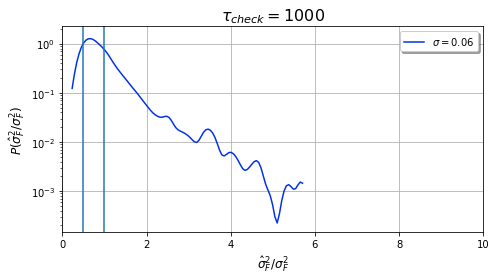

In [416]:
plt.rcParams["figure.figsize"] = (7,4)
norm = mpl.colors.Normalize(vmin=0, vmax=m)
cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.winter)

plt.title(r'$\tau_{check} = 1000$', size = 16)
plt.ylabel('$P(\hat\sigma^2_F/\sigma^2_F) $', size = 12)
plt.xlabel('$\hat\sigma^2_F/\sigma^2_F $', size = 12)
 
density = stats.gaussian_kde(Vf)
a, x, _ = plt.hist(Vf, bins=100, density=True, color = 'white') 
plt.plot(x, density(x),label = r'$\sigma=$'+str(sigma),color = cmap1.to_rgba(m-j))
    
plt.axvline(0.5)
plt.axvline(1)
plt.legend(loc=1, fancybox=True, shadow=True)
plt.yscale('log')
plt.xlim(0.,10)
plt.grid(True)
plt.tight_layout()
plt.savefig(path_to_directory+'changing_world_risk_price.pdf')
plt.show()       

## other stuff

0


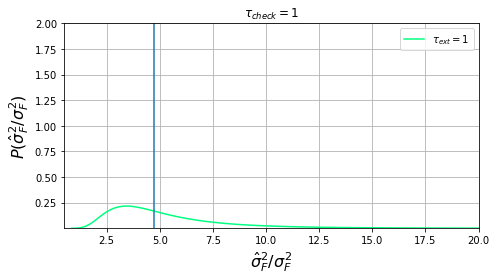

In [777]:
#%timeit

T = 100000
N = 100

hat_var_NT = 1
hat_vars = []
hat_gammas = []
errs = []
m = 1
norm = mpl.colors.Normalize(vmin=0, vmax=m)

cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.winter)

plt.title(r'$\tau_{check} = 1$')
for j in range(0,m):
    print(j)
    hat_variance_F = np.zeros((T+1,N))
    hat_gamma = np.zeros((T+1,N))
    hat_gamma[0] = 0.5
    hat_variance_F[0] = 1
    
    e = np.zeros((T+1,N))
    e[0] = 0
    #alpha = 0.1*j
    tau = 10**j
    #tau = 1
    alpha = np.exp(-1/tau)
    #alpha = 0
    #sigma = 0.1+0.1*j
    ###for uniform
    sigma = 0.06
    S = 2
    for i in range(1,T+1):
        e[i] = alpha*e[i-1] + np.random.normal(0,sigma,N)*np.sqrt(1-alpha**2)
        hat_variance_F[i] = 0.5/(1+S*(S+np.sqrt(1+S**2)))*(1+(S+np.sqrt(1+S**2))**2*(1-e[i])**2/(1+sigma**2)*hat_variance_F[i-1])
        hat_gamma[i] = 0.5/(1+S*(S+np.sqrt(1+S**2)))*(S+np.sqrt(1+S**2))**2*(1-e[i])**2/(1+sigma**2)
        
        #e[i] = np.random.uniform(0.48*2,1.48*2)
        #hat_variance_F[i] = 0.5*(1+e[i]*hat_variance_F[i-1])
        #hat_gamma[i] = 0.5*e[i]
    errs.append(e)
    hat_vars.append(hat_variance_F)
    hat_gammas.append(hat_gamma)

    density = stats.gaussian_kde(hat_variance_F.flatten()/2*(1+S*(S+np.sqrt(1+S**2))))
    a, x, _ = plt.hist(hat_variance_F.flatten()/2*(1+S*(S+np.sqrt(1+S**2))), bins=1000, density=True, color = 'white') 
    plt.plot(x, density(x),label = r'$\tau_{ext} = $'+str(tau),color = cmap1.to_rgba(m-j))
    #plt.plot(x, density(x),label = r'$\sigma = $'+str(round(sigma,2)),color = cmap1.to_rgba(m-j))
    
#plt.legend(fontsize = 10)
plt.legend(loc=1)

plt.ylabel(r'$P(\hat\sigma^2_F/\sigma^2_F)$', size = 16)
plt.xlabel(r'$\hat\sigma^2_F/\sigma^2_F$', size = 16)
plt.axvline(1/2*(1+S*(S+np.sqrt(1+S**2))))
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(0.0000001,2)
plt.xlim(0.5,20)
plt.grid(True)
plt.tight_layout()
plt.savefig(path_to_directory+'changing_world_sigma_risk.pdf')
plt.show()


In [778]:
np.mean(hat_vars[0].transpose()[0])

1.1764408861717657

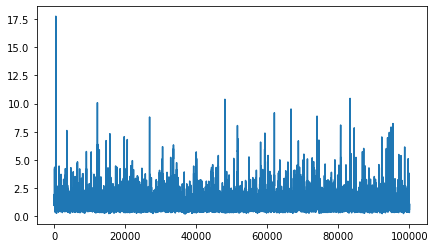

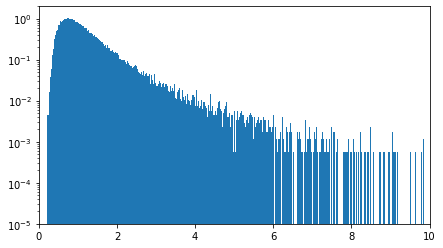

In [781]:
plt.plot(hat_vars[0].transpose()[0])
plt.show()
plt.hist(hat_vars[0].transpose()[0],bins = 1000, density = True)
plt.xlim(0,10)
plt.ylim(10**(-5),2)
plt.yscale('log')
plt.show()

/home/michele/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


4.075746202859756 0.02909503244413162 3.52681924022255


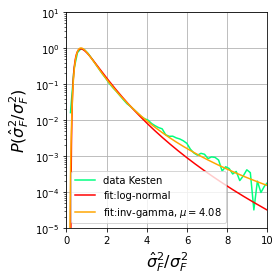

In [1019]:
plt.rcParams["figure.figsize"] = (4,4)
density = stats.gaussian_kde(hat_vars[0].transpose()[0])
a, x, _ = plt.hist(hat_vars[0].transpose()[0], bins=100, density=True, color = 'white') 
plt.plot(x, density(x),label = 'data Kesten',color = cmap1.to_rgba(m-j))
    #plt.plot(x, density(x),label = r'$\sigma = $'+str(round(sigma,2)),color = cmap1.to_rgba(m-j))
#plt.hist(hat_vars[0].transpose()[0],bins = 100, density = True)    
#plt.legend(fontsize = 10)

shape,loc,scale = lognorm.fit(hat_vars[0].transpose()[0])
x = np.arange(0, 2000)/100
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r', label = 'fit:log-normal')

shape,loc,scale = invgamma.fit(hat_vars[0].transpose()[0])

print(shape,loc,scale)

pdf = invgamma.pdf(x, shape, loc, scale)
plt.plot(x, pdf, color = 'orange', label = 'fit:inv-gamma,'+' '+r'$ \mu= $'+str(round(shape,2)))

plt.legend(loc=3)

plt.ylabel(r'$P(\hat\sigma^2_F/\sigma^2_F)$', size = 16)
plt.xlabel(r'$\hat\sigma^2_F/\sigma^2_F$', size = 16)
#plt.axvline(1/2*(1+S*(S+np.sqrt(1+S**2))))
plt.yscale('log')
#plt.xscale('log')
plt.ylim(10**(-5),10)
plt.xlim(0,10)
plt.grid(True)
plt.tight_layout()
plt.savefig(path_to_directory+'changing_world_kesten_risk.pdf')
plt.show()

0.6480172354723 0.1968601188029176 0.7862138136832288


/home/michele/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


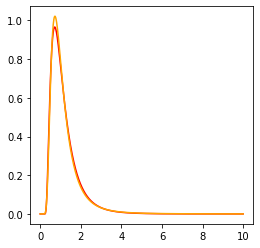

In [812]:
from scipy.stats import lognorm,invgamma
shape,loc,scale = lognorm.fit(hat_vars[0].transpose()[0])
print(shape, loc, scale)
x = np.arange(0, 1000)/100
pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r')

shape,loc,scale = invgamma.fit(hat_vars[0].transpose()[0])
pdf = invgamma.pdf(x, shape, loc, scale)
plt.plot(x, pdf, color = 'orange')



plt.show()

/home/michele/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


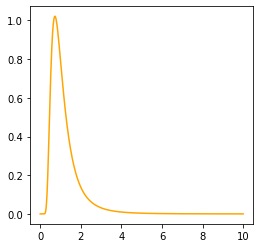

In [811]:
shape,loc,scale = invgamma.fit(hat_vars[0].transpose()[0])
pdf = invgamma.pdf(x, shape, loc, scale)
plt.plot(x, pdf, color = 'orange')

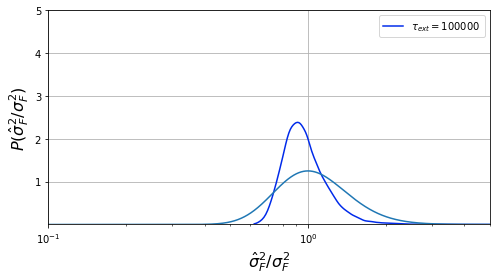

In [497]:
import math
density = stats.gaussian_kde(hat_vars[3].flatten())
a, x, _ = plt.hist(hat_vars[3].flatten(), bins=1000, density=True, color = 'white') 
plt.plot(x, density(x),label = r'$\tau_{ext} = $'+str(tau),color = cmap1.to_rgba(m-j))
x = np.arange(1,100000)/10000
s0 = 10
mu = 10
plt.plot(x,s0**mu*np.exp(-s0/x)/(math.gamma(mu)*x**mu))
    #plt.plot(x, density(x),label = r'$\sigma = $'+str(round(sigma,2)),color = cmap1.to_rgba(m-j))
    
#plt.legend(fontsize = 10)
plt.legend(loc=1)

plt.ylabel(r'$P(\hat\sigma^2_F/\sigma^2_F)$', size = 16)
plt.xlabel(r'$\hat\sigma^2_F/\sigma^2_F$', size = 16)

#plt.yscale('log')
plt.xscale('log')
plt.ylim(0.0000001,5)
plt.xlim(0.1,5)
plt.grid(True)
plt.tight_layout()
#plt.savefig(path_to_directory+'Kesten4.pdf')
plt.show()


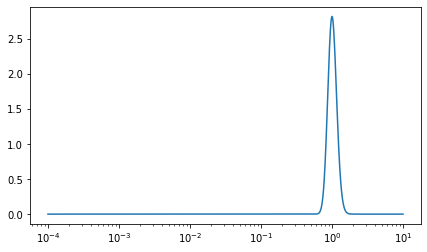

In [493]:
import math
x = np.arange(1,100000)/10000
mu = 50
s0 = 50
plt.plot(x,s0**mu*np.exp(-s0/x)/(math.gamma(mu)*x**mu))
plt.xscale('log')

0
1
2
3
4
5


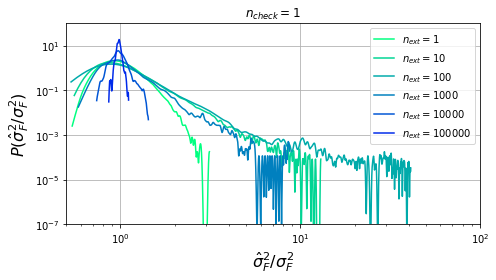

In [1035]:
#%timeit

T = 1000
N = 100

hat_var_NT = 1
hat_vars = []
hat_gammas = []
errs = []
m = 6
norm = mpl.colors.Normalize(vmin=0, vmax=m)

cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.winter)

plt.title(r'$n_{check} = 1$')
for j in range(0,m):
    print(j)
    hat_variance_F = np.zeros((T+1,N))
    hat_gamma = np.zeros((T+1,N))
    hat_gamma[0] = 0.5
    hat_variance_F[0] = 1
    
    e = np.zeros((T+1,N))
    e[0] = 0
    tau = 10**j
    alpha = np.exp(-1/tau)
    #alpha = 0
    #sigma = 0.1+0.1*j
    ###for uniform
    #sigma = 0.1
    for i in range(1,T+1):
        e[i] = alpha*e[i-1] + np.random.normal(0,sigma,N)*np.sqrt(1-alpha**2)
        hat_variance_F[i] = 0.5*(1+(1-e[i])**2/(1+sigma**2)*hat_variance_F[i-1])
        hat_gamma[i] = 0.5*(1-e[i])**2/(1+sigma**2)
        
        #e[i] = np.random.uniform(0.48*2,1.48*2)
        #hat_variance_F[i] = 0.5*(1+e[i]*hat_variance_F[i-1])
        #hat_gamma[i] = 0.5*e[i]
    errs.append(e)
    hat_vars.append(hat_variance_F)
    hat_gammas.append(hat_gamma)

    density = stats.gaussian_kde(hat_variance_F.flatten())
    a, x, _ = plt.hist(hat_variance_F.flatten(), bins=1000, density=True, color = 'white') 
    plt.plot(x, density(x),label = r'$n_{ext} = $'+str(tau),color = cmap1.to_rgba(m-j))
    #plt.plot(x, density(x),label = r'$\sigma = $'+str(round(sigma,2)),color = cmap1.to_rgba(m-j))
    
#plt.legend(fontsize = 10)
plt.legend(loc=1)

plt.ylabel(r'$P(\hat\sigma^2_F/\sigma^2_F)$', size = 16)
plt.xlabel(r'$\hat\sigma^2_F/\sigma^2_F$', size = 16)

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.0000001,100)
plt.xlim(0.5,100)
plt.grid(True)
plt.tight_layout()
plt.savefig(path_to_directory+'Kestentau.pdf')
plt.show()


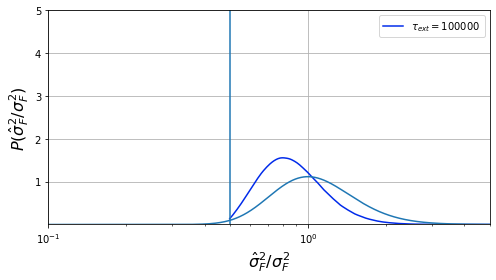

In [503]:
import math
density = stats.gaussian_kde(hat_vars[2].flatten())
a, x, _ = plt.hist(hat_vars[2].flatten(), bins=1000, density=True, color = 'white') 
plt.plot(x, density(x),label = r'$\tau_{ext} = $'+str(tau),color = cmap1.to_rgba(m-j))
x = np.arange(1,100000)/10000
s0 = 8
mu = 8
plt.plot(x,s0**mu*np.exp(-s0/x)/(math.gamma(mu)*x**mu))
    #plt.plot(x, density(x),label = r'$\sigma = $'+str(round(sigma,2)),color = cmap1.to_rgba(m-j))
    
#plt.legend(fontsize = 10)
plt.legend(loc=1)

plt.ylabel(r'$P(\hat\sigma^2_F/\sigma^2_F)$', size = 16)
plt.xlabel(r'$\hat\sigma^2_F/\sigma^2_F$', size = 16)
plt.axvline(0.5)
#plt.yscale('log')
plt.xscale('log')
plt.ylim(0.0000001,5)
plt.xlim(0.1,5)
plt.grid(True)
plt.tight_layout()
#plt.savefig(path_to_directory+'Kesten4.pdf')
plt.show()

0.009991363025755446
0.00996339913849828
0.010073704191545081
0.009584771398502239
0.005362490601466925
0.0010086070091024774


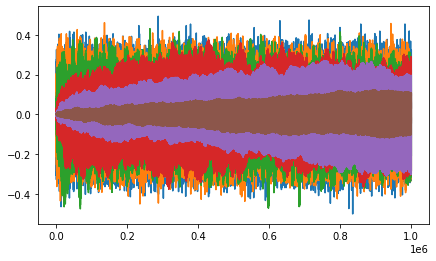

In [444]:
for i in range(0,m):
    plt.plot(errs[i].flatten())
    print(np.mean(errs[i]**2))

0.36027776830545266
0.010000000000000002
0.2497878074416658
0.04000000000000001
0.1598279971073375
0.09000000000000002
0.09003040023568942
0.16000000000000003
0.04006124524015415
0.25
0.009995576232987037
0.36


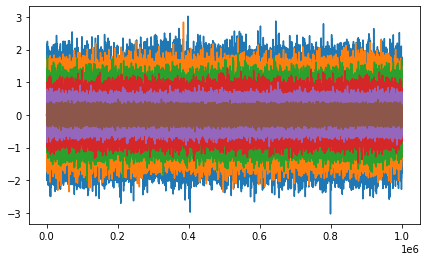

In [449]:
for i in range(0,m):
    plt.plot(errs[m-i-1].flatten())
    print(np.mean(errs[m-i-1]**2))
    print((0.1+0.1*i)*(0.1+0.1*i))

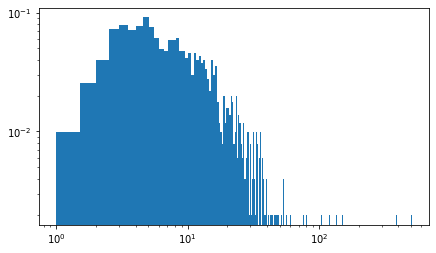

In [429]:
plt.hist(hat_vars[4].flatten(),bins = 1000,density = True)
plt.yscale('log')
plt.xscale('log')
plt.show()

No handles with labels found to put in legend.


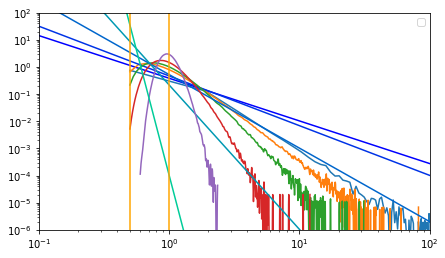

In [411]:
m=5
for i in range(0,m):
    density = stats.gaussian_kde(hat_vars[m-i-1].flatten())
    a, x, _ = plt.hist(hat_vars[m-i-1].flatten(), bins=1000, density=True, color = 'white') 
    plt.plot(x, density(x))
    k = m-i-1
    mu = np.abs(np.mean(np.log(hat_gammas[k])))/(np.mean(np.log(hat_gammas[k])**2)-np.mean(np.log(hat_gammas[k]))**2)
    #plt.hist(hat_vars[m-i-1], bins=1000, density=True, label = r'$\sigma = $'+str(round(0.1+0.1*(m-i-1),2)),color = cmap1.to_rgba(i)) 
    x = np.arange(0.5,100000)/1000
    plt.plot(x,mu*0.5**mu/(x)**(1+mu),color = cmap1.to_rgba(i)) 
plt.axvline(1,color = 'orange')
plt.axvline(0.5,color = 'orange')
plt.yscale('log')
plt.legend(loc=1)
plt.xscale('log')
plt.ylim(0.000001,100)
plt.xlim(0.1,100)
plt.show()

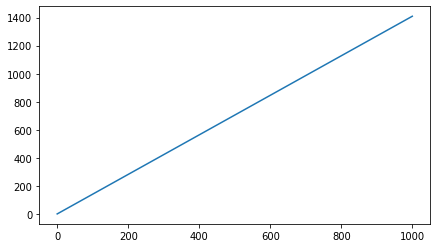

In [410]:
plt.plot(x)

In [409]:
density(x)

array([7.51356985e-01, 1.29095260e-01, 2.41288933e-02, ...,
       7.80598212e-52, 9.04591470e-18, 2.04704536e-06])

In [375]:
k = 1
mu = np.abs(np.mean(np.log(hat_gammas[k])))/(np.mean(np.log(hat_gammas[k])**2)-np.mean(np.log(hat_gammas[k]))**2)
mu

4.34636339347203

In [393]:
k = 0
r =110
np.mean(hat_gammas[k]**r)

1.0332919804076965

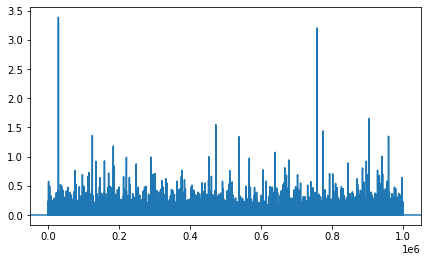

In [389]:
k = 0
r = 10
plt.plot(hat_gammas[0]**r)
plt.axhline(np.mean(hat_gammas[0]**r))
#plt.yscale('log')

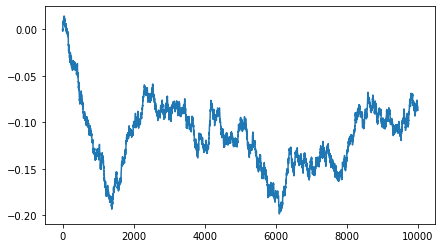

In [768]:
plt.plot(e)

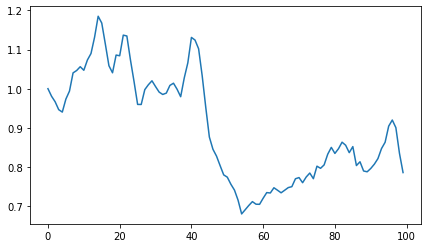

In [741]:
plt.plot(hat_variance_F[:100])

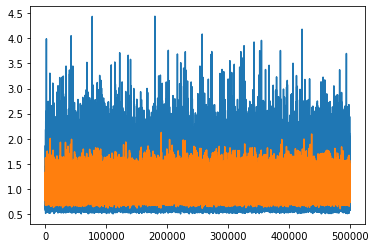

In [478]:
plt.plot(hat_vars[1])
plt.plot(hat_vars[0])

In [ ]:
density = stats.gaussian_kde()
a, x, _ = plt.hist(hat_variance_F, bins=100, density=True, color = 'white') 
plt.plot(x, density(x),label = r'$\sigma=$'+str(round(sigma,2)))

plt.ylabel(r'$\hat\sigma^2_F$')
plt.yscale('log')
plt.legend()
plt.ylim(0.000001,5)
plt.xlim(0,4)
plt.grid(True)
plt.show()

In [410]:
@profile
def test():
    data = np.random.random((5000, 100))
    u, s, v = linalg.svd(data)
    pca = np.dot(u[:, :10], data)
    results = fastica(pca.T, whiten=False)

NameError: name 'profile' is not defined

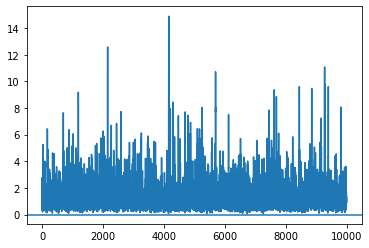

In [350]:
plt.plot(vf)
plt.axhline(0)

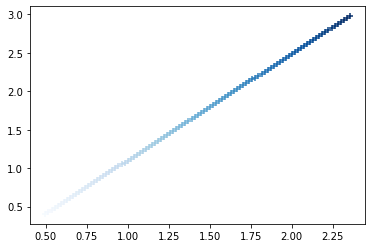

In [326]:

norm = mpl.colors.Normalize(vmin=0, vmax=100)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
for i, xi in enumerate(x):
    plt.scatter(x[i],y[i],color=cmap.to_rgba(i+1),marker = '+')
plt.show()

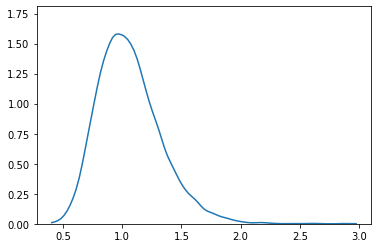

In [321]:

density = stats.gaussian_kde(vf)
n, x, _ = plt.hist(vf, bins=100, density=True, color = 'white') 
plt.plot(x, density(x))
plt.show()

<AxesSubplot:ylabel='Density'>

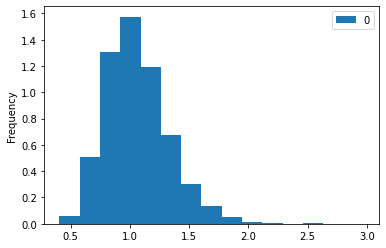

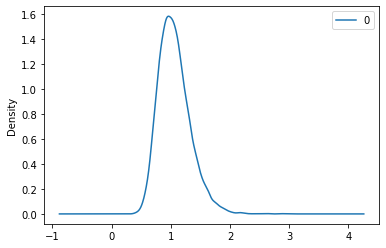

In [311]:
dfvf = pd.DataFrame(vf)
dfvf.plot(kind = "hist", density = True, bins = 15) # change density to true, because KDE uses density
    # Plot KDE
dfvf.plot(kind = "kde")

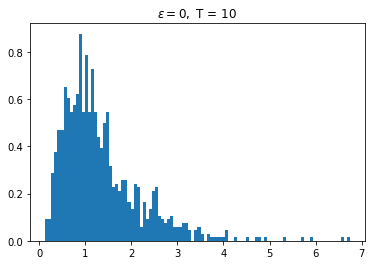

In [302]:
plt.title(r'$\epsilon = 0,$'+' T = '+str(T))
plt.hist(vf, bins = 100,density = True)
plt.savefig(r'$\epsilon = 0,$'+'T = '+str(T)+'.pdf')
plt.show()

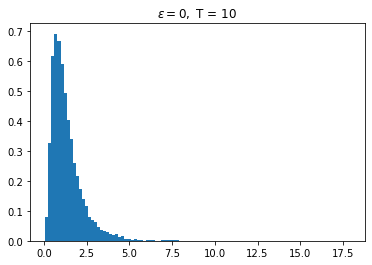

In [291]:
plt.title(r'$\epsilon = 0,$'+' T = '+str(T))
plt.hist(V_F_exp, bins = 100,density = True)
plt.savefig(r'$\epsilon = 0,$'+'T = '+str(T)+'.pdf')
plt.show()